*Role Title and Role Code are similar based on pandas
*Instead of using hashing, can consider cantor(m,n) = 1/2 * (m+n)(m+n+1)+m. Beware of hash collision
*PCA / SVD are more suited for continuous values. For discrete variables, consider using MCA
1. Feature Extraction - Using Genetic Algorithm / Greedy Algorithm [sklearn.feature_selection.RFE, RFECV , Gradient Boosting
2. Try using Stacked Classifier 
  * np.mean
  * weighted mean
  * jaccard score
  * pass the results from each classifer into another RF / Linear Regression
3. Data Exploratory - Find if train has more classes compared to test ? 
4. Try to run on Spark
5. Stratified K Fold Cross Validation

In [1]:
import pandas as pd
from pivottablejs import pivot_ui
import seaborn as sb
import matplotlib.pyplot as plt  
from ipywidgets import widgets
import numpy as np
from sklearn import (metrics, cross_validation, linear_model, preprocessing)
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import (GradientBoostingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn import ensemble
from itertools import combinations
import pickle

%matplotlib inline

sb.set(style="ticks", color_codes=True)
df = pd.read_csv('train.csv')
dft = pd.read_csv('test.csv')
#g = sb.pairplot(df)

In [ ]:
#Observation Only
df.head()

In [ ]:
#len(df['RESOURCE'].value_counts())
#df['RESOURCE'].plot.hist(bins=7518)

#dfc = df.iloc[:,1:10] 
dfc = df.iloc[:,:]
for col in df.columns:
  dfc[col] = df[col].astype('category')

dfc.describe()


In [ ]:
#Observation Only
#test = pd.pivot_table(dfc,index=['ROLE_TITLE','ROLE_CODE'],aggfunc='count',dropna=True)
#dfc.pivot_table(index='ROLE_TITLE',aggfunc=lambda x:len(x.unique()))
mult = {}
for c in df.columns:
    temp = df.pivot_table(index=c,aggfunc=lambda x:len(x.unique()),fill_value=0).apply(np.max)
    mult[c] = temp

multpd = pd.DataFrame(mult)


In [ ]:
def save_results(predictions, filename):
    """Given a vector of predictions, save results in CSV format."""
    with open(filename, 'w') as f:
        f.write("id,ACTION\n")
        for i, pred in enumerate(predictions):
            f.write("%d,%f\n" % (i + 1, pred))


In [ ]:
def cantor(pairs):
    result2 = 0.5 * (pairs[0] + pairs[1]) * (pairs[0] + pairs[1] +1) + pairs[1]
    if(len(pairs) == 2): 
        return result2
    if(len(pairs) == 3 ):
        result3 = 0.5 * (result2 + pairs[2]) * (result2 + pairs[2] +1) + pairs[2]
        return result3
    

In [ ]:
# Convert from dataframe to np.array
y = np.ravel(df.iloc[:,:1])
X = np.array(df.iloc[:,1:9])
X_test = np.array(dft.iloc[:,1:9])
header = list(df.columns[1:])

data = np.vstack((X,X_test))

In [ ]:
# yc = combinations(range(n),2)
# to view all the combinations
# list(yc) 

#train data[:32769,:]
#test data[32769:,:]
#tuple is used here so that the result is hashable

test_offset = 32769
# Get Combinations of 2 features 
for indices in combinations(range(8),2):
    #data = np.column_stack((data,list(ctypes.c_size_t(hash(tuple(v))).value for v in data[:,indices]))) 
    #data = np.column_stack((data,list(np.uint64(hash(tuple(v))) for v in data[:,indices]))) 
    #data = np.column_stack((data,list(hash(tuple(v)) for v in data[:,indices]))) 
    data = np.column_stack((data,list(cantor(tuple(v)) for v in data[:,indices]))) 
    a,b = indices
    header.append(header[a] +"&"+ header[b])
print('2 Combinations')
print(data.shape)
print(np.any(data < 0))
print(np.ndarray.min(data))
print(np.ndarray.max(data))
    
# Get Combinations of 3 features 
for indices in combinations(range(8),3):
    data = np.column_stack((data,list(cantor(tuple(v)) for v in data[:,indices]))) 
    a,b,c = indices
    header.append(header[a] +"&"+ header[b]+ "&" + header[c])

    
#Check loaded correctly with non-zero elements    
print('3 Combinations')
print(data.shape)
print(np.any(data < 0))
print(np.ndarray.min(data))
print(np.ndarray.max(data))

In [ ]:


# Simplify the encoding. Probably not essential. Could possibly improve performance
# Vertical Stacking is required so that all the features are captured. There might be some features in test set not in train set

le = preprocessing.LabelEncoder()
data_e = []
# To perform column wise operations, use Transpose function
for i in data.T:
    le.fit(i)
    data_e.append(le.transform(i))

data = np.asarray(data_e).T

print(np.any(data < 0))
print(np.ndarray.min(data))
print(np.ndarray.max(data))



In [ ]:
# #Code to help Visualize what the algorithm is doing 
# t_data = []
# test_data = np.array([[1,2,3,4],[1,2,2,0],[1,2,3,4],[1,4,5,6],[2,3,4,5]])
# print(test_data.shape)

# #if the combination of categories are the same, they will be hashed to the same value. Eg 1 row with (0,1,0) will have same 
# #hash value of another row with (0,1,0)
# for indices in combinations(range(4),2):
#     t_data.append(hash(tuple(v)) for v in test_data[:,indices])
#     #print(v for v in test_data[:,indices])
#     print(indices)
    
# #Comparison 1 - Combinations are (0,1),(0,2),(0,3),(1,2),(1,3),(2,3)
# # for v in test_data[:,(0,1)]:
# #   print(hash(tuple(v)))

# #Comparison 2 - t_data[0] corresponds to (0,1)
# #tuple(t_data[0])

In [139]:
#Initial Encoding

encoder = preprocessing.OneHotEncoder(dtype=np.uint32)
# we want to encode the category IDs encountered both in
# the training and the test set, so we fit the encoder on both
encoder.fit(data)
X = encoder.transform(data[:test_offset,:])
X_test = encoder.transform(data[test_offset:,:])
print(X.shape)
print(X_test.shape)

# encoder = preprocessing.OneHotEncoder()
# encoder.fit(data)
# X = encoder.transform(X)
# X_test = encoder.transform(X_test)

(32769, 1595040)
(58921, 1595040)


In [ ]:
print("Total One Hot Features",encoder.active_features_)
print("Boundaries of each Feature",len(encoder.feature_indices_),encoder.feature_indices_)
print("Number of unique values in each feature",len(encoder.n_values_),encoder.n_values_)
# print(np.unique(data[:,0]))
# print(np.unique(data[:,1]))
sb.barplot(x=np.arange(92),y=encoder.n_values_)


In [106]:
#inside a ipython/nb session
# %store encoder
# %store data
# %store X
# %store X_test
# %store y
# %store features
# %store header
# %store test_offset

# %store -r encoder
# %store -r data
# %store -r X
# %store -r X_test
# %store -r y
# %store -r features
# %store -r header
# %store -r test_offset


Stored 'test_offset' (int)


In [7]:
#Feature Selection - Gradient Boosting (Filtering)
dtc = DecisionTreeClassifier(criterion='entropy')
dtc.fit(X,y)
print(dtc.feature_importances_)
features = dtc.feature_importances_

#sb.distplot(feat,bins=100)
#print(np.argmax(features),np.max(features))
# Sum features in the same bin as defined by encoder.n_values_
x = 0
start = 0
prob_sum = []
#prob_ref = dict()
for i in encoder.n_values_ : 
    prob = features[start:i].sum()
    prob_sum.append(prob)
    #prob_ref[header[x]] = prob 
    start = i + 1
    #x += 1

[ 0.          0.          0.         ...,  0.          0.          0.00328731]


In [ ]:
# Stability Selection using Randomized Lasso

rlasso = linear_model.RandomizedLogisticRegression(C=1)
rlasso.fit(X,y)

rlasso_score = rlasso.scores_

x = 0
start = 0
prob_sum = []
for i in encoder.n_values_ : 
    prob_sum.append(rlasso_score[start:i].sum())
    start = i + 1

print(rlasso_score)
print(prob_sum)


In [ ]:
#Feature Selection - Greedy Algorithm (Wrapping)

estimator = linear_model.LogisticRegression(C=1)
selector = RFE(estimator)
selector = selector.fit(X, y)
selector.ranking_

[0, 3, 4, 6, 8, 10, 11, 12, 13, 16, 17, 18, 19, 22, 23, 24, 26, 27, 28, 30, 31, 33, 35, 36, 37, 38, 39, 40, 43, 44, 45, 47, 48, 49, 51, 52, 54, 56, 58, 59, 60, 63, 64, 66, 67, 69, 71, 73, 74, 76, 77, 79, 81, 82, 83, 85, 87, 88, 90]


['RESOURCE',
 'ROLE_ROLLUP_2',
 'ROLE_DEPTNAME',
 'ROLE_FAMILY_DESC',
 'ROLE_CODE',
 'RESOURCE&ROLE_ROLLUP_1',
 'RESOURCE&ROLE_ROLLUP_2',
 'RESOURCE&ROLE_DEPTNAME',
 'RESOURCE&ROLE_TITLE',
 'MGR_ID&ROLE_ROLLUP_1',
 'MGR_ID&ROLE_ROLLUP_2',
 'MGR_ID&ROLE_DEPTNAME',
 'MGR_ID&ROLE_TITLE',
 'ROLE_ROLLUP_1&ROLE_ROLLUP_2',
 'ROLE_ROLLUP_1&ROLE_DEPTNAME',
 'ROLE_ROLLUP_1&ROLE_TITLE',
 'ROLE_ROLLUP_1&ROLE_FAMILY',
 'ROLE_ROLLUP_2&ROLE_DEPTNAME',
 'ROLE_ROLLUP_2&ROLE_TITLE',
 'ROLE_ROLLUP_2&ROLE_FAMILY',
 'ROLE_DEPTNAME&ROLE_TITLE',
 'ROLE_DEPTNAME&ROLE_FAMILY',
 'ROLE_TITLE&ROLE_FAMILY',
 'ROLE_FAMILY_DESC&ROLE_FAMILY',
 'RESOURCE&MGR_ID&ROLE_ROLLUP_1',
 'RESOURCE&MGR_ID&ROLE_ROLLUP_2',
 'RESOURCE&MGR_ID&ROLE_DEPTNAME',
 'RESOURCE&MGR_ID&ROLE_TITLE',
 'RESOURCE&ROLE_ROLLUP_1&ROLE_ROLLUP_2',
 'RESOURCE&ROLE_ROLLUP_1&ROLE_DEPTNAME',
 'RESOURCE&ROLE_ROLLUP_1&ROLE_TITLE',
 'RESOURCE&ROLE_ROLLUP_1&ROLE_FAMILY',
 'RESOURCE&ROLE_ROLLUP_2&ROLE_DEPTNAME',
 'RESOURCE&ROLE_ROLLUP_2&ROLE_TITLE',
 'RESOURCE

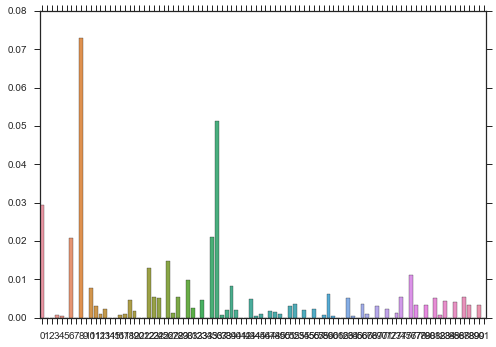

In [133]:
sb.barplot(y=prob_sum,x=np.arange(92))
#hsb = sb.hist(prob_sum,xlim=0.1)
#Look at bar plot to see what threshold of the features to select
ufeatures = []
for i,j in enumerate(prob_sum):
    if (j>0) : ufeatures.append(i)
print(ufeatures)
[header[i] for i in ufeatures]


In [134]:
encode_bfeat = preprocessing.OneHotEncoder(dtype=np.uint32)
# we want to encode the category IDs encountered both in
# the training and the test set, so we fit the encoder on both
encode_bfeat.fit(data[:,ufeatures])
X = encode_bfeat.transform(data[:test_offset,ufeatures])
X_test = encode_bfeat.transform(data[test_offset:,ufeatures])
print(X.shape)
print(X_test.shape)

(32769, 1259056)
(58921, 1259056)


In [137]:
SEED = 42
mean_auc = 0.0

n = 10  # repeat the CV procedure 10 times to get more precise results
model = linear_model.LogisticRegression(C=1)
#model = BernoulliNB(alpha=0.005)
for i in range(n):
    # for each iteration, randomly hold out 20% of the data as CV set
    X_train, X_cv, y_train, y_cv = cross_validation.train_test_split(X, y, test_size=.20, random_state=i*SEED)

    # if you want to perform feature selection / hyperparameter
    # optimization, this is where you want to do it

    # train model and make predictions
    model.fit(X_train, y_train) 
    preds = model.predict_proba(X_cv)[:, 1]

    # compute AUC metric for this CV fold
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, preds)
    roc_auc = metrics.auc(fpr, tpr)
    print("AUC (fold %d/%d): %f" % (i + 1, n, roc_auc))
    mean_auc += roc_auc

print("Mean AUC: %f" % (mean_auc/n))

# === Predictions === #
# When making predictions, retrain the model on the whole training set
model.fit(X, y)
preds = model.predict_proba(X_test)[:, 1]
save_results(preds, "submit.csv")

AUC (fold 1/10): 0.883359
AUC (fold 2/10): 0.881408
AUC (fold 3/10): 0.891638
AUC (fold 4/10): 0.899944
AUC (fold 5/10): 0.883712
AUC (fold 6/10): 0.889287
AUC (fold 7/10): 0.874977
AUC (fold 8/10): 0.884113
AUC (fold 9/10): 0.882565
AUC (fold 10/10): 0.892604
Mean AUC: 0.886361


NameError: name 'save_results' is not defined

In [ ]:
# Numpy Operations
# print(np.fromiter(t_data[0],np.int32))
# print(np.fromiter(t_data[1],np.int32))
# print(np.fromiter(t_data[2],np.int32))
# print(np.fromiter(t_data[3],np.int32))
# print(np.fromiter(t_data[4],np.int32))
# print(np.fromiter(t_data[5],np.int32))

# Convert to numpy array - Use np.array(list)
# for i in nparray - iterate through rows
# for i in nparray.T - iterate through columns
# Initialize np.zeros(5)

# To view generator operators (Use list,tuples)
# for i,j in enumerate(t_data):
#     #lst_array[i] = np.array(list(j))
#     lst_array[i] = np.fromiter(j,np.float)

AUC = Logistic Regression returns the probability that a certain input features would be in a certain class
ROC curve visualizaes all possible thresholds
Misclassification rate is error rate for a single threshold


Attempt with original features only : CV : ... , Public : 0.88515, Private : 0.88205

Attempt with original features + combination of 3 : CV : 0.886361 , Public : 0.90141, Private 0.89582 

Attempt with DTC selected features : CV :  0.886555 (threshold >0) , Public : , Private 

Attempt with Random Lasso  : CV :   , Public : , Private 